## Generative Adversarial Networks

- **Image classification**: Assigning a label to an image based on its content.
- Convolutional Neural Networks (CNNs) have brought groundbreaking changes in this field.
- CNNs are specialized neural networks for processing grid-like data (e.g., images).

- Extending CNNs to Generate Images
  - A fascinating feature of CNNs: Their adaptability.
  - While they excel in classification, they can also be repurposed to generate images.
  - Think of it as "reverse engineering" 
    - given the learned features, how might an image look?

- GANs: The New Era of Image Generation
  - A novel architecture involving two networks: A generator and a discriminator.
  - These networks train together, continuously improving each other.
  - The goal? 
    - Have the generator create images so good that the discriminator can't tell them apart from real ones.

- GANs in Action: A Real-world Analogy
  - Picture a bank (the discriminator) trying to spot fake money from a counterfeiter (the generator).
  - Initially, the counterfeiter's fakes are obvious. 
    - But let the money forger have a spy in the bank that reports back how the bank is telling fakes apart from real money.
  - A continuous cycle of adaptation and counter-adaptation ensues.

- The Discriminator and Generator in Detail
  - **Discriminator**: A CNN trained to assign a probability that an image is real.
  - **Generator**: A specialized CNN using transpose convolutions (or deconvolutions). It starts with random noise (around 100 parameters) and crafts an image from it.


<img src="./images/GAN6.png" width="500" align="center"/>

- How Does the Discriminator "Guide" the Generator?
  - The discriminator, being a convolutional neural network, is differentiable.
  - By backpropagating, we can identify the gradients of the input image.
  - These gradients inform the generator which parts of the image to tweak.

- Utilizing the Feedback
  - With the gradient information, we can adjust the weights of the generative network.
  - This ensures that subsequent images produced by the generator are more "authentic" in appearance.

- A Continuous Tug-of-War
  - The discriminator seeks disparities between fake and real images.
  - The generator aims to blur these lines of differentiation.
  - Over time, this competition refines the generator to a point where its output becomes indistinguishable from real images.

- Real-world Implementation
  - Implementing GANs requires a deep learning framework, e.g., PyTorch.
  - The true test: Training the network on diverse image datasets like CIFAR-10 or 64x64 Imagenet samples.


<img src="./images/border.jpg" height="10" width="1500" align="center"/>

Generated CIFAR images on iteration 300, 900, and 5700.

<img src="./images/GAN2.png" width="500" align="center"/>

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

Real images on the left, generated at iteration 182,000 on the right

<img src="./images/GAN3.png" width="500" align="center"/>

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

What happens if we scale it up? CIFAR is only 32x32, so let's try Imagenet. I downloaded a 150,000 image set from the Imagenet 2012 Challenge, and rescaled them all to 64x64.

- Generated Imagenet images on iteration 300, 800, and 5800.

<img src="./images/GAN4.jpeg" width="500" align="center"/>


- Real images on the left, generated at iteration 17,800 on the right

<img src="./images/GAN5.jpeg" width="500" align="center"/>


<img src="./images/border.jpg" height="10" width="1500" align="center"/>

# Genereative Adversarial Networks


<img src="./images/gan_architecture.png" width="70%"/>

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 1.0
lr = 2e-4
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999
batch_size = 256
epochs = 100
plot_every = 10

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

## Generator

- Its primary role is to produce or "generate" data.

- Latent Vector: The Starting Point
  - Generators begin with a random vector.
  - This is similar to the latent vector used in autoencoders.
  - Acts as the seed or source from which data will be generated.

- How Does the Generator Produce Images?
  - Transforms the initial random vector.
  - Uses a series of neural network layers to shape and refine this vector.
  - The output is our target image.

- Parallels with Autoencoders
  - The generator's process mirrors the generative side of an autoencoder.
  - Both start with a compressed representation (latent vector) and expand it.
  - However, while autoencoders reconstruct from known data, generators create new data.

- Building a Generator
  - Many architectures can be employed. Linear neural networks are one such choice.
  - The choice of architecture can be influenced by the dataset in use.


In our example, we will use linear neural networks and MNIST dataset.


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256, momentum=0.2)
        self.linear2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512, momentum=0.2)
        self.linear3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024, momentum=0.2)
        self.linear4 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, input):
        hidden1 = self.leaky_relu(self.bn1(self.linear1(input)))
        hidden2 = self.leaky_relu(self.bn2(self.linear2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.linear3(hidden2)))
        generated = self.tanh(self.linear4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated

## Enhancing Generators: A Few Tricks

Generative models often require a few tricks up their sleeves to improve stability and performance. 

#### 1. LeakyReLU Activation

- Traditional ReLU: `f(x) = max(0, x)`
- **LeakyReLU**: A twist on the traditional ReLU.
  - Not strictly 0 for negative `x`.
  - Instead, it has a small positive gradient/slope.
  - Helps the network learn even for negative values of `x`.

#### 2. BatchNorm1D

- **BatchNorm1D**: A form of normalization applied to 1D inputs.
  - Helps in stabilizing training.
  - Can accelerate convergence.
  - Reduces the sensitivity to initialization.

#### 3. Tanh Activation for the Final Layer

- The **Tanh** activation function outputs values between [-1,1].
- Preferred for certain types of generative tasks.
- Ensures the generated data remains within a specific range.




<img src="./images/border.jpg" height="10" width="1500" align="center"/>

## Discriminator

Discriminator is a classical image classification network. In our first example, we will also use linear classifier.

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = input.view(input.shape[0], -1)
        hidden1 = self.leaky_relu(self.linear1(input))
        hidden2 = self.leaky_relu(self.linear2(hidden1))
        classififed = self.sigmoid(self.linear3(hidden2))
        return classififed

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

## Loading dataset

We will use MNIST dataset.

In [5]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [6]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)
])

In [7]:
train_dataset, test_dataset = mnist(train_size, transform)

100%|██████████| 9912422/9912422 [00:01<00:00, 8994562.74it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26208501.48it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 15108875.61it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7980950.47it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

## Network training

On each step of the training, we have **two** phases:

* **Generator** training. We generate some random vectors **noise** (training happens in minibatches, so we use 100 vectors at a time), generate **true labels** (vector with shape (bs, 1) with 1.0 values), calculate generator loss between output from **frozen** discriminator with noise as input and true labels.

* **Discriminator** training. We calculate discriminator loss from **two** parts, **first** part is loss between output from discriminator with noise as input and **fake labels** (vector with shape (bs, 1) with 0.0 values), **second** part is loss between output from discriminator with real images as input and true labels (vector with shape (bs, 1) with 1.0 values). **Result loss** is (first_part_loss + second_part_loss) / 2.

In [9]:
def plotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [10]:
def train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]
    
    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    for epoch in tqdm_iter:
        gen.train()
        disc.train()

        train_gen_loss = 0.0
        train_disc_loss = 0.0
        
        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)

            disc.eval()
            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)
            
            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.train()
            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            plotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

  0%|          | 0/100 [00:00<?, ?it/s]

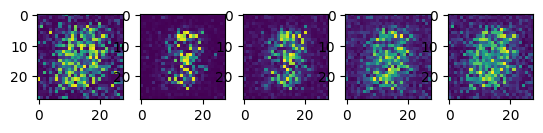

 10%|█         | 10/100 [02:14<19:32, 13.03s/it, generator loss:=1.1, discriminator loss:=0.527] 

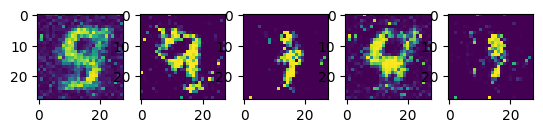

 20%|██        | 20/100 [04:19<16:43, 12.55s/it, generator loss:=0.995, discriminator loss:=0.579]

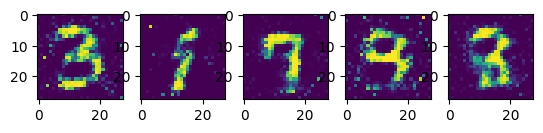

 30%|███       | 30/100 [06:28<15:17, 13.10s/it, generator loss:=0.892, discriminator loss:=0.62] 

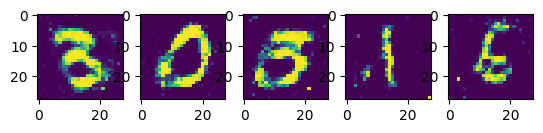

 40%|████      | 40/100 [08:41<13:31, 13.53s/it, generator loss:=0.862, discriminator loss:=0.633]

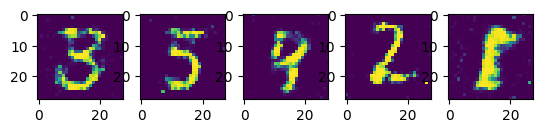

 50%|█████     | 50/100 [10:53<11:02, 13.25s/it, generator loss:=0.844, discriminator loss:=0.637]

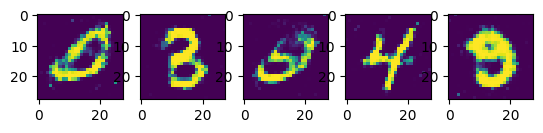

 60%|██████    | 60/100 [13:09<09:05, 13.63s/it, generator loss:=0.842, discriminator loss:=0.638]

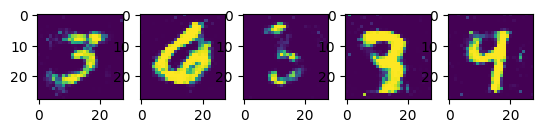

 70%|███████   | 70/100 [15:28<06:51, 13.72s/it, generator loss:=0.845, discriminator loss:=0.636]

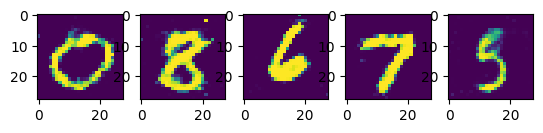

 80%|████████  | 80/100 [17:42<04:29, 13.48s/it, generator loss:=0.852, discriminator loss:=0.633]

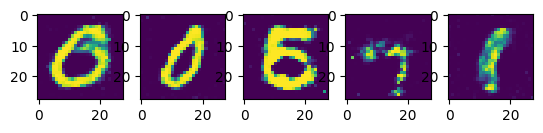

 90%|█████████ | 90/100 [20:01<02:20, 14.07s/it, generator loss:=0.858, discriminator loss:=0.631]

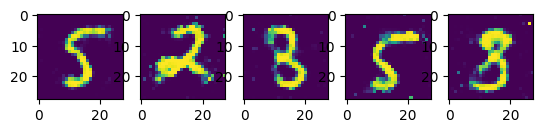

 99%|█████████▉| 99/100 [22:03<00:13, 13.50s/it, generator loss:=0.864, discriminator loss:=0.629]

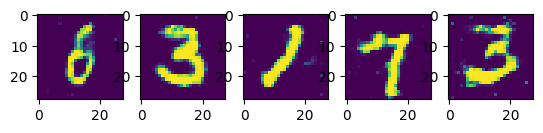

100%|██████████| 100/100 [22:18<00:00, 13.38s/it, generator loss:=0.868, discriminator loss:=0.627]


In [12]:
train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device)

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

## DCGAN

**Deep Convolutional GAN** is pretty obvious idea of using convolutional layers for generator and discriminator. The main difference here is using **Conv2DTranspose** layer in the generator.

<img src="images/dcgan_generator.png" width="60%"/>

> Image from [this tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.relu(self.bn1(self.conv1(input)))
        hidden2 = self.relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.relu(self.bn3(self.conv3(hidden2)))
        generated = self.tanh(self.conv4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

In [ ]:
class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.leaky_relu(self.conv1(input))
        hidden2 = self.leaky_relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.conv3(hidden2)))
        classified = self.sigmoid(self.conv4(hidden3)).view(input.shape[0], -1)
        return classified

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

Weights initialization from [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) paper.

In [ ]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
])

In [ ]:
train_dataset, test_dataset = mnist(train_size, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

In [ ]:
generator = DCGenerator().to(device)
generator.apply(weights_init)
discriminator = DCDiscriminator().to(device)
discriminator.apply(weights_init)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

In [ ]:
def dcplotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100, 1, 1))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [ ]:
def train_dcgan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]
    
    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]
    
    gen.train()
    disc.train()

    for epoch in tqdm_iter:
        train_gen_loss = 0.0
        train_disc_loss = 0.0
        
        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)
            imgs = 2.0 * imgs - 1.0

            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100, 1, 1))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)
            
            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            dcplotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

  0%|          | 0/50 [00:00<?, ?it/s]

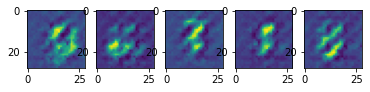

 10%|█         | 5/50 [00:53<08:03, 10.74s/it, generator loss:=2.38, discriminator loss:=0.256]

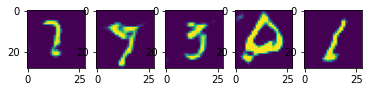

 20%|██        | 10/50 [01:47<07:03, 10.58s/it, generator loss:=2.12, discriminator loss:=0.254]

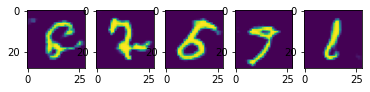

 30%|███       | 15/50 [02:40<06:12, 10.66s/it, generator loss:=2.2, discriminator loss:=0.255] 

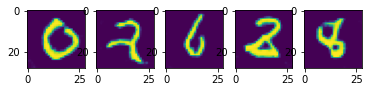

 40%|████      | 20/50 [03:33<05:17, 10.57s/it, generator loss:=2.21, discriminator loss:=0.266]

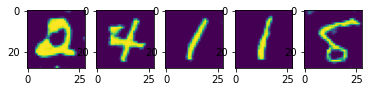

 50%|█████     | 25/50 [04:27<04:24, 10.60s/it, generator loss:=2.34, discriminator loss:=0.229]

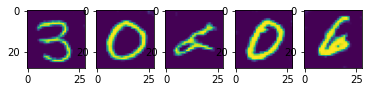

 60%|██████    | 30/50 [05:20<03:32, 10.65s/it, generator loss:=2.42, discriminator loss:=0.225]

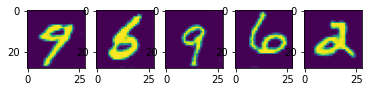

 70%|███████   | 35/50 [06:13<02:39, 10.60s/it, generator loss:=2.55, discriminator loss:=0.216]

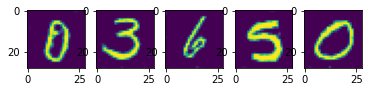

 80%|████████  | 40/50 [07:07<01:46, 10.62s/it, generator loss:=2.62, discriminator loss:=0.207]

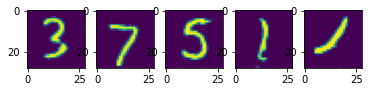

 90%|█████████ | 45/50 [08:00<00:52, 10.55s/it, generator loss:=2.8, discriminator loss:=0.178] 

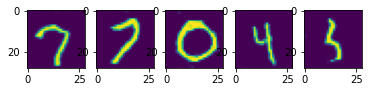

 98%|█████████▊| 49/50 [08:43<00:10, 10.65s/it, generator loss:=2.77, discriminator loss:=0.2]  

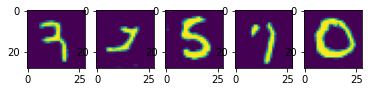

100%|██████████| 50/50 [08:54<00:00, 10.68s/it, generator loss:=2.79, discriminator loss:=0.184]


In [ ]:
train_dcgan(dataloaders, models, optimizers, loss_fn, epochs // 2, plot_every // 2, device)

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

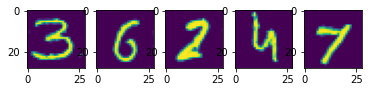

In [ ]:
generator.eval()
dcplotn(5, generator, device)

<img src="./images/border.jpg" height="10" width="1500" align="center"/>

> **Task**: Try generating more complex color images with DCGAN - for example, take one class from [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html) dataset.

## Training on Paintings

One of the good candidates for GAN training are paintings created by human artists.

![](https://soshnikov.com/images/artartificial/Flo1.jpg)

(Photo from [Art of Artificial](https://soshnikov.com/museum/art-artificial/) collection)

<img src="./images/border.jpg" height="10" width="1500" align="center"/>